# Cell 1: Setup and Master Configuration
**This cell handles all installations, imports, model downloads, and contains a single configuration section for all your settings.**

In [15]:
# ==============================================================================
#  1. SETUP: INSTALL AND IMPORT LIBRARIES
# ==============================================================================
# For local environments (like Anaconda), uncomment these lines to install libraries.
# !pip install pandas openpyxl transformers torch tqdm textblob seaborn nltk scikit-learn
# !pip install huggingface_hub[hf_xet]
# !pip install --upgrade Pillow==9.5.0

# --- Import Libraries ---
import pandas as pd
import os
import re
import string
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from transformers import pipeline
from tqdm.auto import tqdm
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, bigrams, trigrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from openpyxl.drawing.image import Image

# --- Download NLP Models ---
# This section ensures all necessary data models are available.
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('brown', quiet=True) # For TextBlob
!python -m textblob.download_corpora --quiet
!python -m spacy download en_core_web_md --quiet

# Register tqdm for use with pandas .progress_apply()
tqdm.pandas(desc="Processing Verbatims")

# ==============================================================================
#  2. 🔴 MASTER USER CONFIGURATION 🔴
# ==============================================================================

# --- Input File Details ---
# For Kaggle, the path is typically '/kaggle/input/your-dataset-name/your-file-name.xlsx'
FILE_PATH = r'/kaggle/input/ck-verbatim/Verbatim Analysis Data 01.00.xlsx'
TEXT_COLUMN_NAME = 'Still not solved'

# --- Output File Details ---
OUTPUT_FOLDER_PATH = r'/kaggle/working/' # Correct for Kaggle
PROGRAM_NAME = "Cloud Kitchens"
KPIS_IN_SCOPE = "CSAT-AHT-Resolution_Time"
LOBS_IN_SCOPE = "Support-Scaled"
MAJOR_VERSION = 1 # Manually change for new datasets or category versions

# --- Analysis Settings ---
CUSTOM_STOP_WORDS = {'company',str(PROGRAM_NAME),str(KPIS_IN_SCOPE),str(LOBS_IN_SCOPE)}
TOPIC_MODEL_TOPICS = 5 # Number of topics for LDA analysis
CLASSIFICATION_THRESHOLD = 0.45 # Confidence score (0.0 to 1.0) for categorization

# --- Define Your Zero-Shot Categories and Sub-Categories (Granular Version) ---
CATEGORIES = {
    # --- People Driven Categories ---
    'Interaction with Call Center Agent': [
        "Call agent's communication and listening skills",
        "Call agent's knowledge and problem-solving ability",
        "Call agent's attitude empathy and professionalism",
        "Efficiency and speed of call handling or resolution",
    ],
    'Interaction with In-Store Staff': [
        "In-store staff's helpfulness and attitude",
        "Staff's product knowledge and ability to answer questions",
        "Availability and attentiveness of staff in the store",
        "Efficiency of in-store processes like checkout or returns",
    ],
    'Interaction with Field Technician': [
        "Technician's professionalism, timeliness, and communication",
        "Technician's skill and ability to fix the issue",
        "Cleanliness and care taken by the technician in the home",
        "Explanation of work performed by the technician",
    ],

    # --- Process Driven Category ---
    'Company Process or Policy Issue': [
        'Confusion or disagreement with a company policy',
        'The overall process was too complex or had too many steps',
        'The total time it took to resolve the issue',
        'Problems with a follow-up, callback, or promised contact',
    ],

    # --- Technical and System Categories ---
    'Website or Online Portal Issue': [
        "Website was slow, lagging, or unresponsive", # CORRECTED THIS LINE
        'Difficulty navigating or finding information on the website',
        'A website bug, glitch, or error message',
        'The website crashed, froze, or was unavailable',
    ],
    'Mobile Application Issue': [
        'The mobile app was slow or had poor performance',
        'A bug or error in the mobile app',
        'The mobile app crashed or froze',
        'The mobile app was difficult to use or understand',
    ],
    'Communication Channel Quality': [
        'Poor audio quality, static, or bad phone connection',
        'Loud background noise during a call',
        'Issues with the live chat tool or functionality',
        'Problems with email communication or response times',
    ],

    # --- Product Driven Category ---
    'Feedback on the Product Itself': [
        'The quality, a defect, or damage of the product',
        'A suggestion or request for a new product feature',
        'Feedback on the price, cost, or value for money',
        'The design, appearance, or general ease of use of the product',
    ]
}

print("✅ Setup complete. All libraries and models are ready.")

[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /usr/share/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 55.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the packag

# Cell 2: Data Loading, Cleaning, and Sentiment Analysis
**This cell prepares your core DataFrame by loading, cleaning, and running sentiment analysis.**

✅ Successfully loaded 183 rows from '/kaggle/input/ck-verbatim/Verbatim Analysis Data 01.00.xlsx'.

--- Data Preview with Cleaned Text and Sentiment ---


,Still not solved,cleaned_text,sentiment_label
0,Agent said they would look into and get back t...,agent said would look get back tomorrow confid...,Negative
1,je n'ai pas eu le temps d'expliquer mon probleme,nai pa temp dexpliquer mon probleme,Neutral
2,Did not resolve my issue. Simply trying to pri...,resolve issue simply trying print otter invoic...,Negative
3,"still waiting,",still waiting,Neutral
4,POPMENU ordering ticket does not print out the...,popmenu ordering ticket print modifier,Neutral


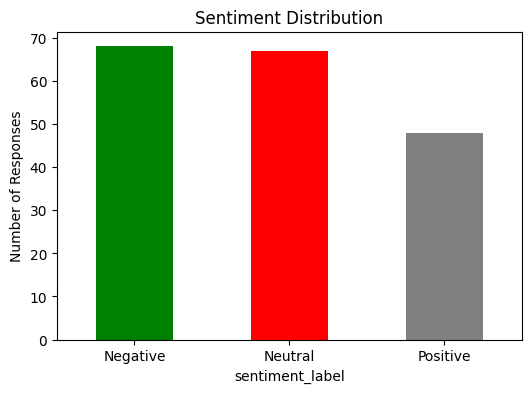

In [16]:
# --- 1. Load Data Safely ---
# This block will attempt to load your file. If it fails, it will print an error and stop.
try:
    df = pd.read_excel(FILE_PATH)
    print(f"✅ Successfully loaded {len(df)} rows from '{FILE_PATH}'.")
    
    # --- 2. Text Cleaning ---
    stop_words = set(stopwords.words('english')).union(CUSTOM_STOP_WORDS)
    lemmatizer = WordNetLemmatizer()
    def clean_text(text):
        if not isinstance(text, str): return ""
        text = text.lower()
        text = re.sub(r'[\d\n]', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text.strip())
        cleaned_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
        return " ".join(cleaned_tokens)
    
    df.dropna(subset=[TEXT_COLUMN_NAME], inplace=True)
    df['cleaned_text'] = df[TEXT_COLUMN_NAME].apply(clean_text)
    
    # --- 3. Sentiment Analysis ---
    sia = SentimentIntensityAnalyzer()
    df['sentiment_compound'] = df[TEXT_COLUMN_NAME].apply(lambda x: sia.polarity_scores(x)['compound'])
    def categorize_sentiment(compound):
        if compound >= 0.05: return 'Positive'
        if compound <= -0.05: return 'Negative'
        return 'Neutral'
    df['sentiment_label'] = df['sentiment_compound'].apply(categorize_sentiment)

    print("\n--- Data Preview with Cleaned Text and Sentiment ---")
    display(df[[TEXT_COLUMN_NAME, 'cleaned_text', 'sentiment_label']].head())

    # --- 4. Plot Sentiment Distribution and Save ---
    plt.figure(figsize=(6, 4))
    df['sentiment_label'].value_counts().plot(kind='bar', color=['green', 'red', 'grey'])
    plt.title('Sentiment Distribution')
    plt.ylabel('Number of Responses')
    plt.xticks(rotation=0)
    plt.savefig(os.path.join(OUTPUT_FOLDER_PATH, 'sentiment_distribution.png'), bbox_inches='tight')
    plt.show()

except FileNotFoundError:
    print("="*80)
    print(f"❌ FATAL ERROR: File not found at the specified path.")
    print(f"   Your specified path: '{FILE_PATH}'")
    print("   Please check the 'FILE_PATH' variable in your configuration cell and try again.")
    print("="*80)
    # Raising the error stops the notebook execution
    raise

# Cell 3: Exploratory Analysis (Frequency, N-grams, Word Clouds)
**This cell prepares frequency tables and word cloud images for the final report.**

--- Top 20 Most Common Words ---


,Word,Frequency
0,issue,26
1,still,26
2,time,24
3,need,20
4,agent,19
5,otter,19
6,get,17
7,email,17
8,please,15
9,help,14


--- Top 10 Most Common Bigrams ---


,Bigram
0,return label
1,still waiting
2,issue resolved
3,uber eats
4,resolve issue
5,solve problem
6,issue still
7,otter tablet
8,account cancellation
9,requested return


--- Top 10 Most Common Trigrams ---


,Trigram
0,requested return label
1,tried connect via
2,please hurry fix
3,still need help
4,issue still waiting
5,time solve problem
6,received inquiry regarding
7,inquiry regarding return
8,regarding return label
9,return label otter


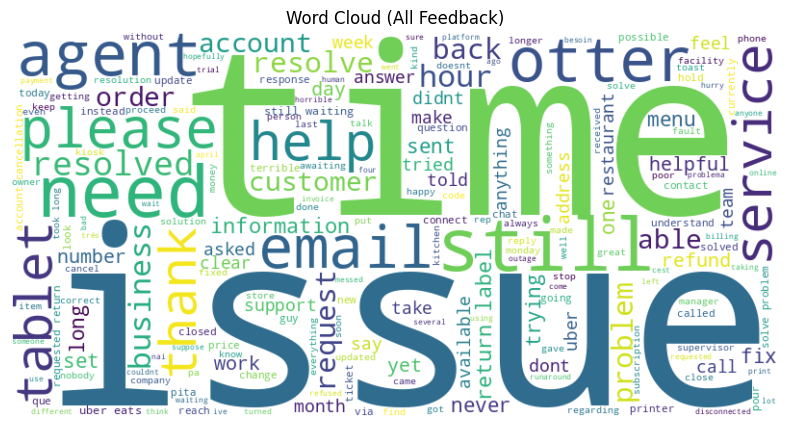

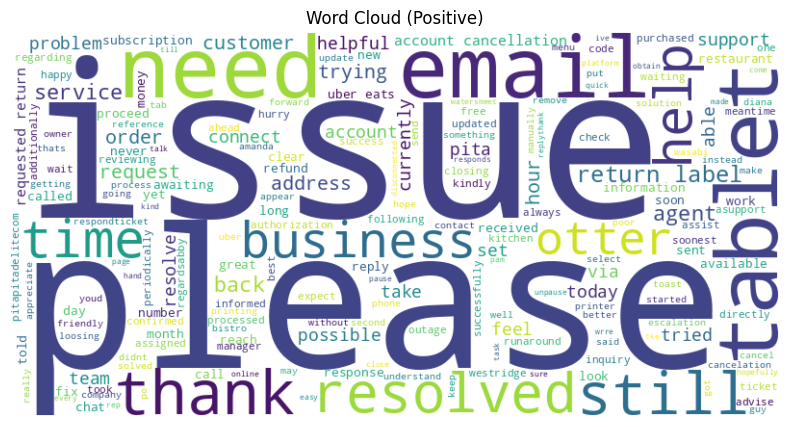

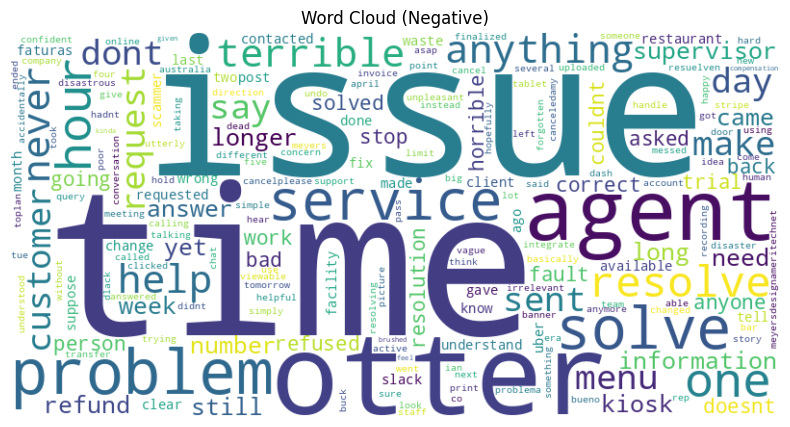

In [17]:
# --- 1. Prepare Overall Text and Tokens ---
all_cleaned_text = " ".join(df['cleaned_text'])
all_tokens = word_tokenize(all_cleaned_text)

# --- 2. Create and Store Frequency Tables ---
fdist = FreqDist(all_tokens)
df_top_words = pd.DataFrame(fdist.most_common(20), columns=['Word', 'Frequency'])

bigram_fdist = FreqDist(list(bigrams(all_tokens)))
df_top_bigrams = pd.DataFrame([' '.join(gram) for gram, freq in bigram_fdist.most_common(10)], columns=['Bigram'])

trigram_fdist = FreqDist(list(trigrams(all_tokens)))
df_top_trigrams = pd.DataFrame([' '.join(gram) for gram, freq in trigram_fdist.most_common(10)], columns=['Trigram'])

print("--- Top 20 Most Common Words ---")
display(df_top_words)

print("--- Top 10 Most Common Bigrams ---")
display(df_top_bigrams)

print("--- Top 10 Most Common Trigrams ---")
display(df_top_trigrams)

# --- 3. Generate and Save Word Clouds ---
def generate_and_save_wordcloud(text, title, filename):
    if not text.strip():
        print(f"Skipping '{title}' word cloud: No text available.")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(os.path.join(OUTPUT_FOLDER_PATH, filename), bbox_inches='tight')
    plt.show()

generate_and_save_wordcloud(all_cleaned_text, 'Word Cloud (All Feedback)', 'wordcloud_all.png')
generate_and_save_wordcloud(" ".join(df[df.sentiment_label == 'Positive']['cleaned_text']), 'Word Cloud (Positive)', 'wordcloud_positive.png')
generate_and_save_wordcloud(" ".join(df[df.sentiment_label == 'Negative']['cleaned_text']), 'Word Cloud (Negative)', 'wordcloud_negative.png')

# Cell 4: Thematic Analysis (Topic Modeling and Zero-Shot Categorization)
**This cell performs the main "what are they talking about?" analyses.**

In [18]:
# --- 1. Topic Modeling (LDA) ---
print("\n--- Discovering Latent Topics (LDA) ---")
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_text'].dropna())
if dtm.shape[0] > 1 and dtm.shape[1] > 1:
    lda = LatentDirichletAllocation(n_components=TOPIC_MODEL_TOPICS, random_state=42)
    lda.fit(dtm)
    topic_results = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        top_words_str = ", ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])
        topic_results.append([f"Topic #{topic_idx + 1}", top_words_str])
    df_topics = pd.DataFrame(topic_results, columns=['Discovered Topic', 'Top Words'])
    display(df_topics)
else:
    print("Not enough data to perform topic modeling.")
    df_topics = pd.DataFrame() # Create empty df if it fails

# --- 2. Zero-Shot Root Cause Categorization ---
print("\n--- Loading Zero-Shot Classification model ---")
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def get_multi_label_predictions(text, labels, threshold):
    if not text or not isinstance(text, str): return []
    results = classifier(text, candidate_labels=labels, multi_label=True)
    return [label for i, label in enumerate(results['labels']) if results['scores'][i] >= threshold]

def extract_key_phrases(text):
    return "|".join([str(p) for p in TextBlob(text).noun_phrases[:3]]) if text else ""

def categorize_row(row):
    text = row[TEXT_COLUMN_NAME]
    matched_cats = get_multi_label_predictions(text, list(CATEGORIES.keys()), CLASSIFICATION_THRESHOLD)
    matched_subcats = []
    if matched_cats:
        for cat in matched_cats:
            sub_preds = get_multi_label_predictions(text, CATEGORIES.get(cat, []), CLASSIFICATION_THRESHOLD)
            matched_subcats.extend(sub_preds)
        if not matched_subcats and (key_phrases := extract_key_phrases(text)):
            matched_subcats.append(f"SUGGESTION: {key_phrases}")
    return "|".join(matched_cats) if matched_cats else 'Uncategorized', "|".join(matched_subcats) if matched_subcats else ""

print(f"\n--- Starting Zero-Shot categorization with a threshold of {CLASSIFICATION_THRESHOLD:.2f} ---")
df[['Category', 'Sub-Category']] = df.progress_apply(categorize_row, axis=1, result_type='expand')

print("\n--- Categorization Complete ---")


--- Discovering Latent Topics (LDA) ---


,Discovered Topic,Top Words
0,Topic #1,"menu, fix, thank, account, problem, trying, as..."
1,Topic #2,"issue, service, resolved, set, order, customer..."
2,Topic #3,"email, tablet, help, otter, request, need, acc..."
3,Topic #4,"time, agent, need, business, uber, answer, say..."
4,Topic #5,"otter, issue, resolve, long, hour, waiting, so..."



--- Loading Zero-Shot Classification model ---


Device set to use cuda:0



--- Starting Zero-Shot categorization with a threshold of 0.45 ---


Processing Verbatims:   0%|          | 0/183 [00:00<?, ?it/s]


--- Categorization Complete ---


# Cell 5: Deep-Dive Categorization Analysis
**This cell is dedicated to analyzing the results of our categorization, creating the tables and charts needed for the executive summary.**


--- Categorization Summary ---


,Metric,Value
0,Total Verbatims,183
1,Categorized,165
2,Uncategorized,18
3,Categorization Rate,90.16%



--- Sentiment Breakdown by Category ---


sentiment_label,Negative,Neutral,Positive
Category,,,
Website or Online Portal Issue,42,36,29
Interaction with Call Center Agent,43,34,27
Communication Channel Quality,37,36,25
Mobile Application Issue,31,31,21
Company Process or Policy Issue,32,33,17
Interaction with Field Technician,18,20,11
Interaction with In-Store Staff,14,13,14
Feedback on the Product Itself,10,6,6
Uncategorized,5,11,2



--- Sentiment Breakdown by Sub-Category ---


sentiment_label,Negative,Neutral,Positive
Sub-Category,,,
Difficulty navigating or finding information on the website,41,33,25
"Website was slow, lagging, or unresponsive",39,29,25
Confusion or disagreement with a company policy,31,30,16
Problems with email communication or response times,27,29,17
"Problems with a follow-up, callback, or promised contact",29,30,12
A bug or error in the mobile app,28,26,16
The mobile app was slow or had poor performance,29,22,19
The overall process was too complex or had too many steps,31,28,11
Issues with the live chat tool or functionality,25,24,13



--- Top Keywords in Uncategorized Verbatims ---


,Keyword,Frequency
0,pa,2
1,ticket,2
2,issue,2
3,turned,2
4,printer,2
5,code,2
6,order,2
7,human,2
8,agent,2
9,one,2



--- Calculating and Plotting Overall Frequencies ---


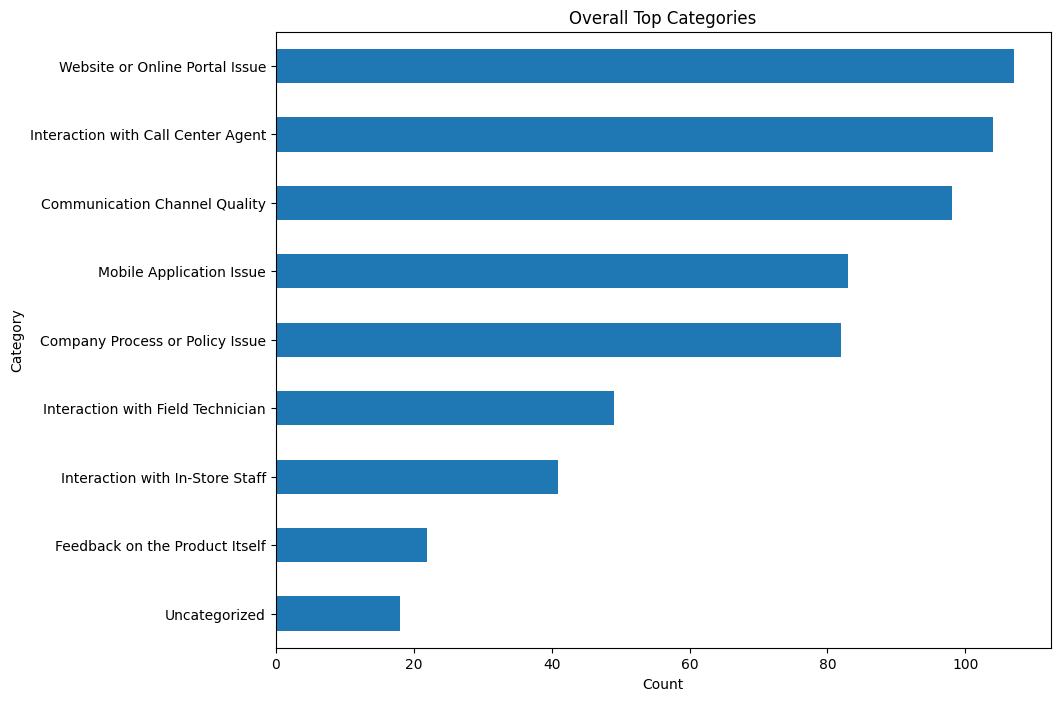

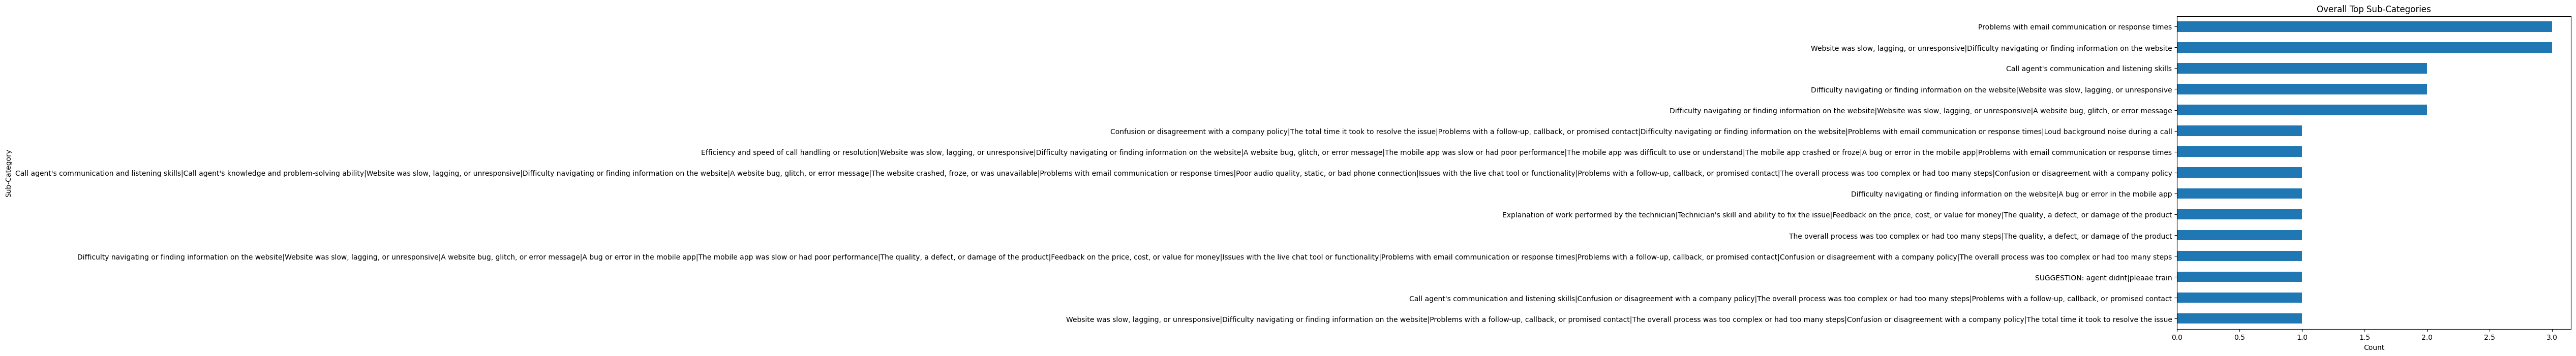


--- Calculating and Plotting Frequencies by Sentiment ---


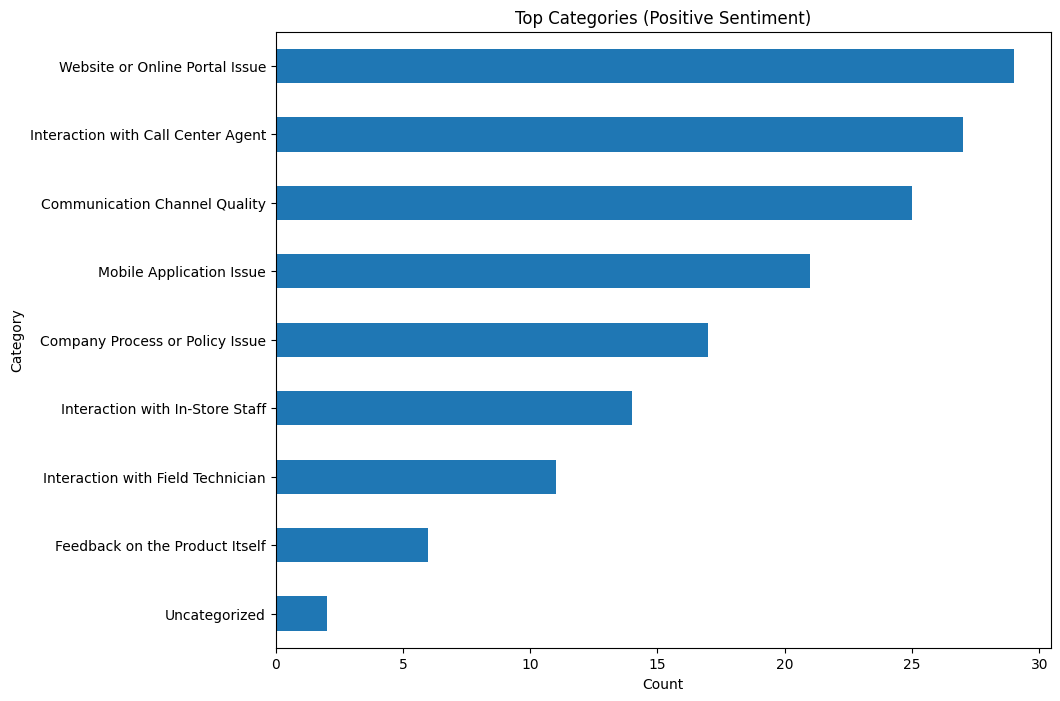

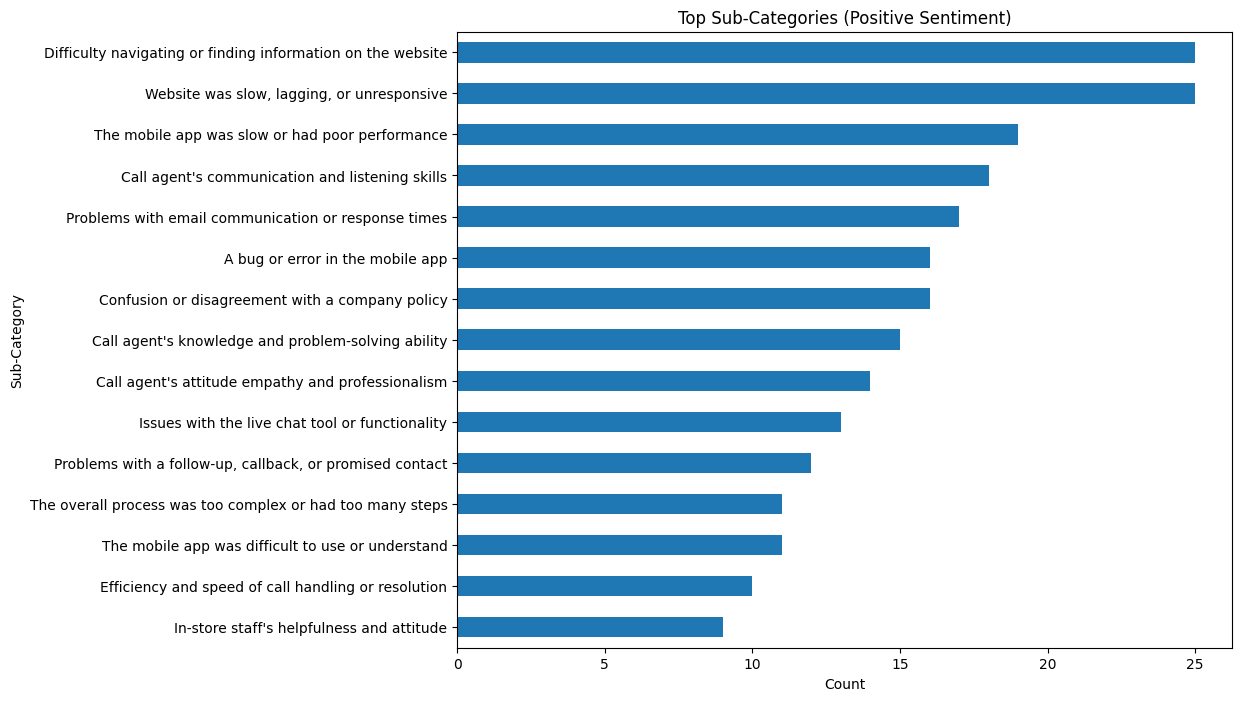

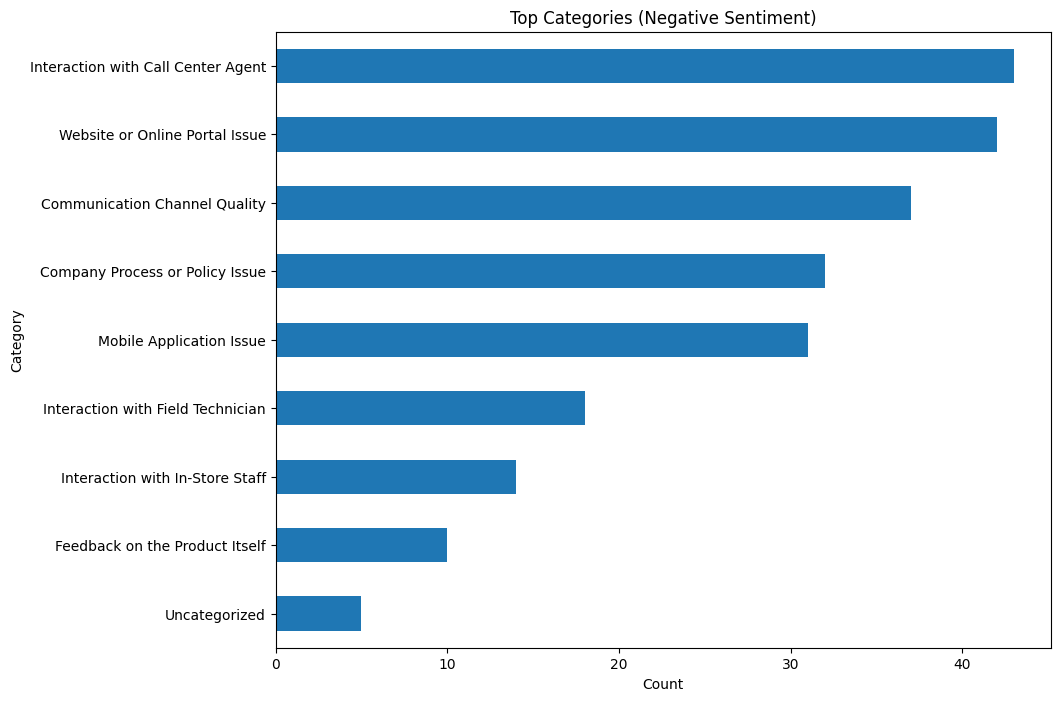

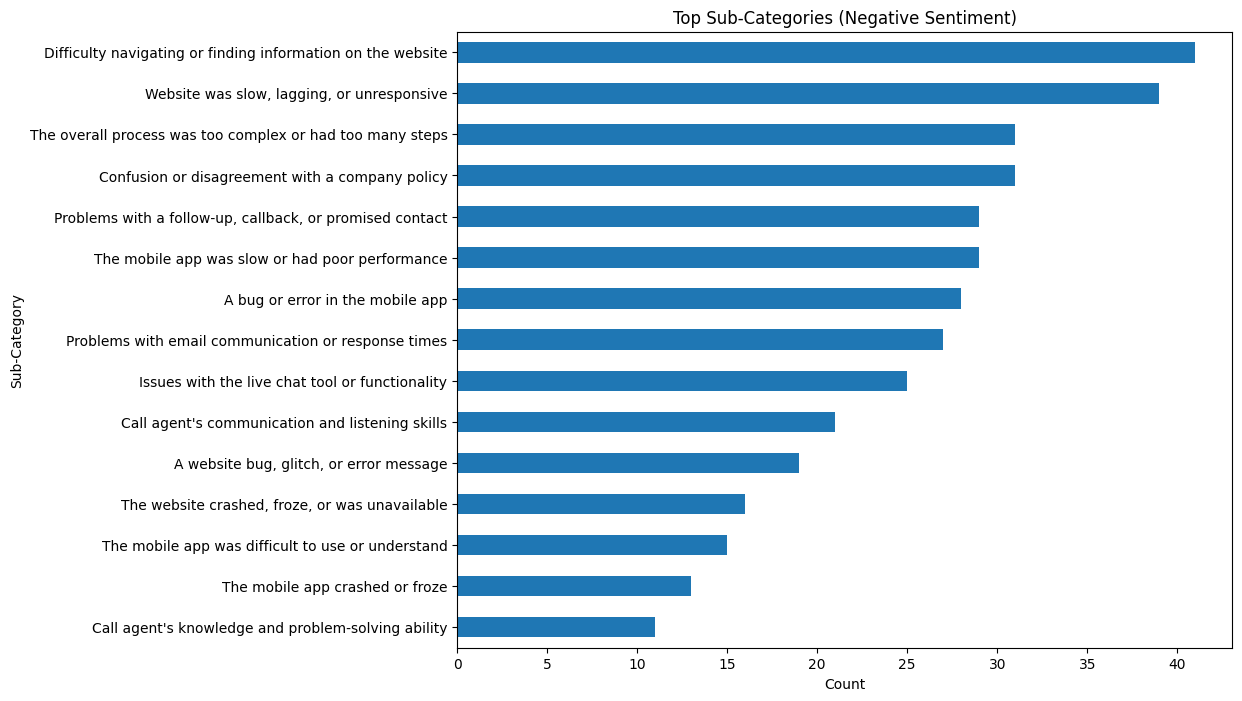

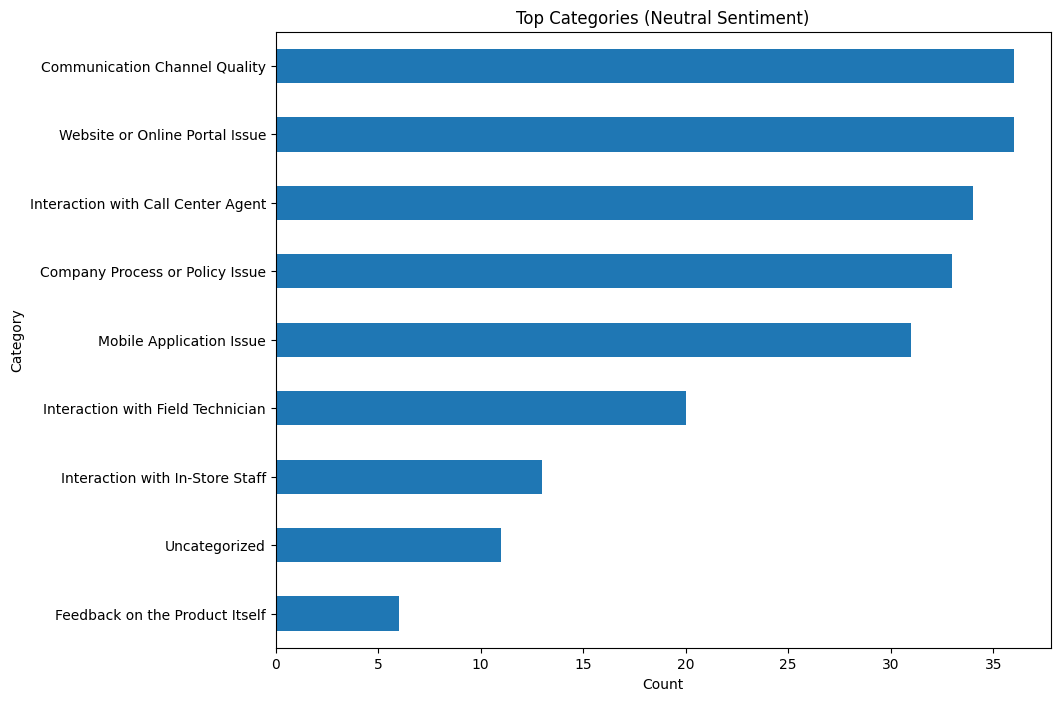

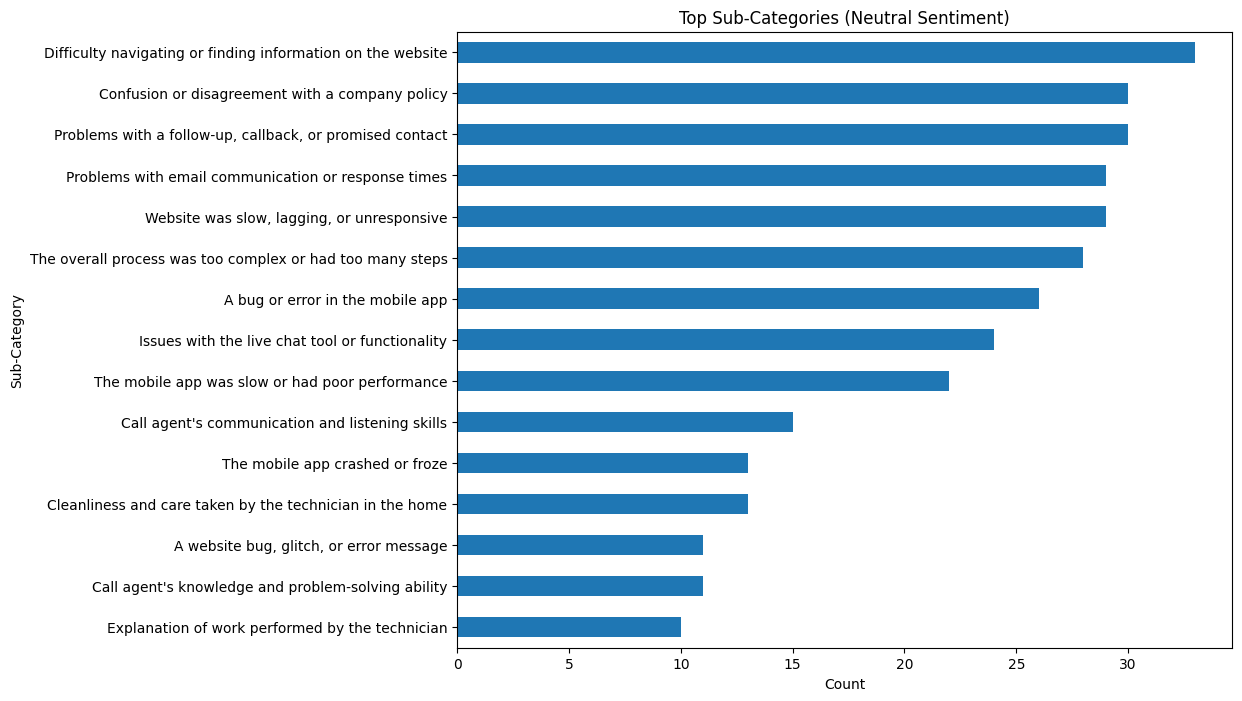

In [19]:
# --- 1. Categorization Summary ---
total_rows = len(df)
uncategorized_count = len(df[df['Category'] == 'Uncategorized'])
categorized_count = total_rows - uncategorized_count
categorization_rate = (categorized_count / total_rows) * 100 if total_rows > 0 else 0
print("\n--- Categorization Summary ---")
summary_metrics = {
    'Metric': ['Total Verbatims', 'Categorized', 'Uncategorized', 'Categorization Rate'],
    'Value': [total_rows, categorized_count, uncategorized_count, f"{categorization_rate:.2f}%"]
}
df_summary_metrics = pd.DataFrame(summary_metrics)
display(df_summary_metrics)

# --- 2.1. Sentiment Breakdown by Category ---
print("\n--- Sentiment Breakdown by Category ---")
df_exploded_cat = df.assign(Category=df['Category'].str.split('|')).explode('Category')
df_sentiment_by_cat = pd.crosstab(df_exploded_cat['Category'], df_exploded_cat['sentiment_label'])

df_sentiment_by_cat['Total'] = df_sentiment_by_cat.sum(axis=1)
df_sentiment_by_cat = df_sentiment_by_cat.sort_values(by='Total', ascending=False)
df_sentiment_by_cat = df_sentiment_by_cat.drop(columns='Total')

display(df_sentiment_by_cat)

# --- 2.2. Sentiment Breakdown by Sub-Category ---
print("\n--- Sentiment Breakdown by Sub-Category ---")
df_temp = df.copy()
df_temp['Sub-Category'] = df_temp['Sub-Category'].str.split('|')
df_exploded_subcat = df_temp.explode('Sub-Category')
df_sentiment_by_subcat = pd.crosstab(
    df_exploded_subcat['Sub-Category'],
    df_exploded_subcat['sentiment_label']
)

df_sentiment_by_subcat['Total'] = df_sentiment_by_subcat.sum(axis=1)
df_sentiment_by_subcat = df_sentiment_by_subcat.sort_values(by='Total', ascending=False)
df_sentiment_by_subcat = df_sentiment_by_subcat.drop(columns='Total')

display(df_sentiment_by_subcat)

# --- 3. Top Keywords for "Uncategorized" Verbatims ---
print("\n--- Top Keywords in Uncategorized Verbatims ---")
uncategorized_text = " ".join(df[df['Category'] == 'Uncategorized']['cleaned_text'])
uncategorized_fdist = FreqDist(word_tokenize(uncategorized_text))
df_uncategorized_keywords = pd.DataFrame(uncategorized_fdist.most_common(20), columns=['Keyword', 'Frequency'])
display(df_uncategorized_keywords.head(10))

# --- 4. Category and Sub-Category Frequency Analysis & Visualization ---
def plot_and_save_top_n(series, title, filename, n=15):
    """Helper function to plot and save frequency charts."""
    if series.empty:
        print(f"Skipping plot '{title}': No data.")
        return
    plt.figure(figsize=(10, 8))
    # Plot the top N items in ascending order for the horizontal bar chart
    series.head(n).sort_values(ascending=True).plot(kind='barh')
    plt.title(title)
    plt.xlabel('Count')
    plt.savefig(os.path.join(OUTPUT_FOLDER_PATH, filename), bbox_inches='tight')
    plt.show()

# --- Calculate and Plot Overall Frequencies ---
print("\n--- Calculating and Plotting Overall Frequencies ---")
# Explode categories to get individual counts
df_exploded_cat = df.assign(Category=df['Category'].str.split('|')).explode('Category')
df_cat_counts = df_exploded_cat['Category'].value_counts()

# Explode sub-categories to get individual counts
df_exploded_subcat = df.assign(SubCategory=df['Sub-Category'].str.split('|')).explode('Sub-Category')
df_subcat_counts = df_exploded_subcat['Sub-Category'].value_counts()

# Plot the results
plot_and_save_top_n(df_cat_counts, 'Overall Top Categories', 'freq_cat_overall.png')
plot_and_save_top_n(df_subcat_counts.drop('', errors='ignore'), 'Overall Top Sub-Categories', 'freq_subcat_overall.png')


# --- Calculate and Plot Frequencies Split by Sentiment ---
print("\n--- Calculating and Plotting Frequencies by Sentiment ---")
for sentiment in ['Positive', 'Negative', 'Neutral']:
    # Filter the DataFrame for the current sentiment
    df_sentiment = df[df['sentiment_label'] == sentiment].copy()
    if df_sentiment.empty:
        continue # Skip if no data for this sentiment

    # --- Process and Plot Categories for the sentiment ---
    df_sentiment['Category'] = df_sentiment['Category'].str.split('|')
    cat_counts = df_sentiment.explode('Category')['Category'].value_counts()
    plot_and_save_top_n(cat_counts, f'Top Categories ({sentiment} Sentiment)', f'freq_cat_{sentiment.lower()}.png')

    # --- Process and Plot Sub-Categories for the sentiment ---
    df_sentiment['Sub-Category'] = df_sentiment['Sub-Category'].str.split('|')
    subcat_counts = df_sentiment.explode('Sub-Category')['Sub-Category'].value_counts()
    plot_and_save_top_n(subcat_counts.drop('', errors='ignore'), f'Top Sub-Categories ({sentiment} Sentiment)', f'freq_subcat_{sentiment.lower()}.png')

# Cell 6: Similarity Analysis (Jaccard & Semantic)
**This cell performs the deeper analysis on vocabulary overlap and semantic relationships.**

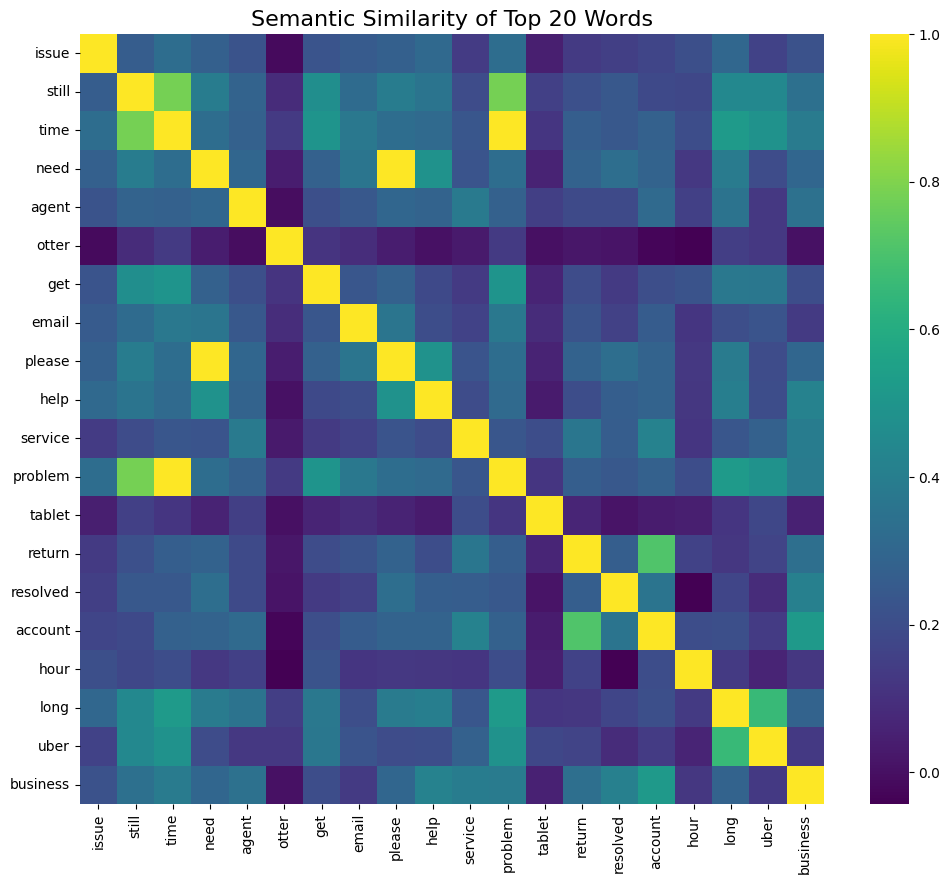

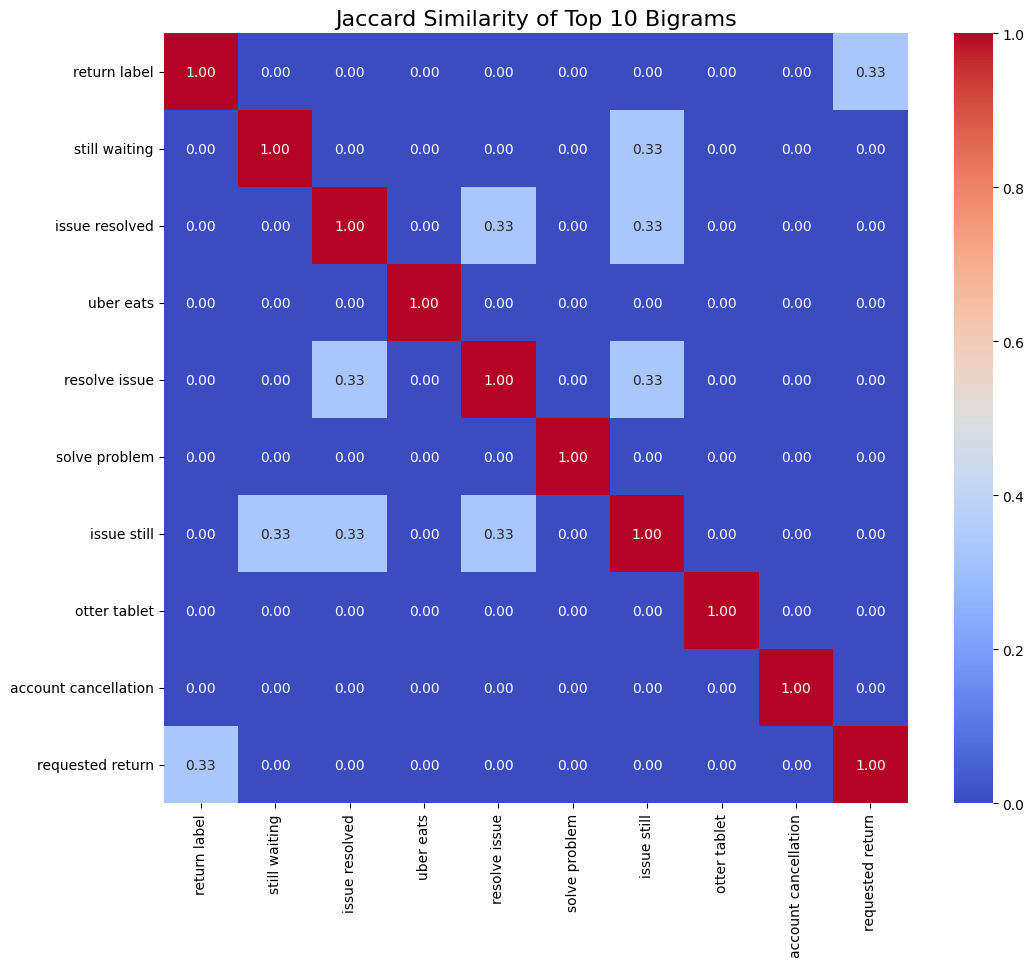

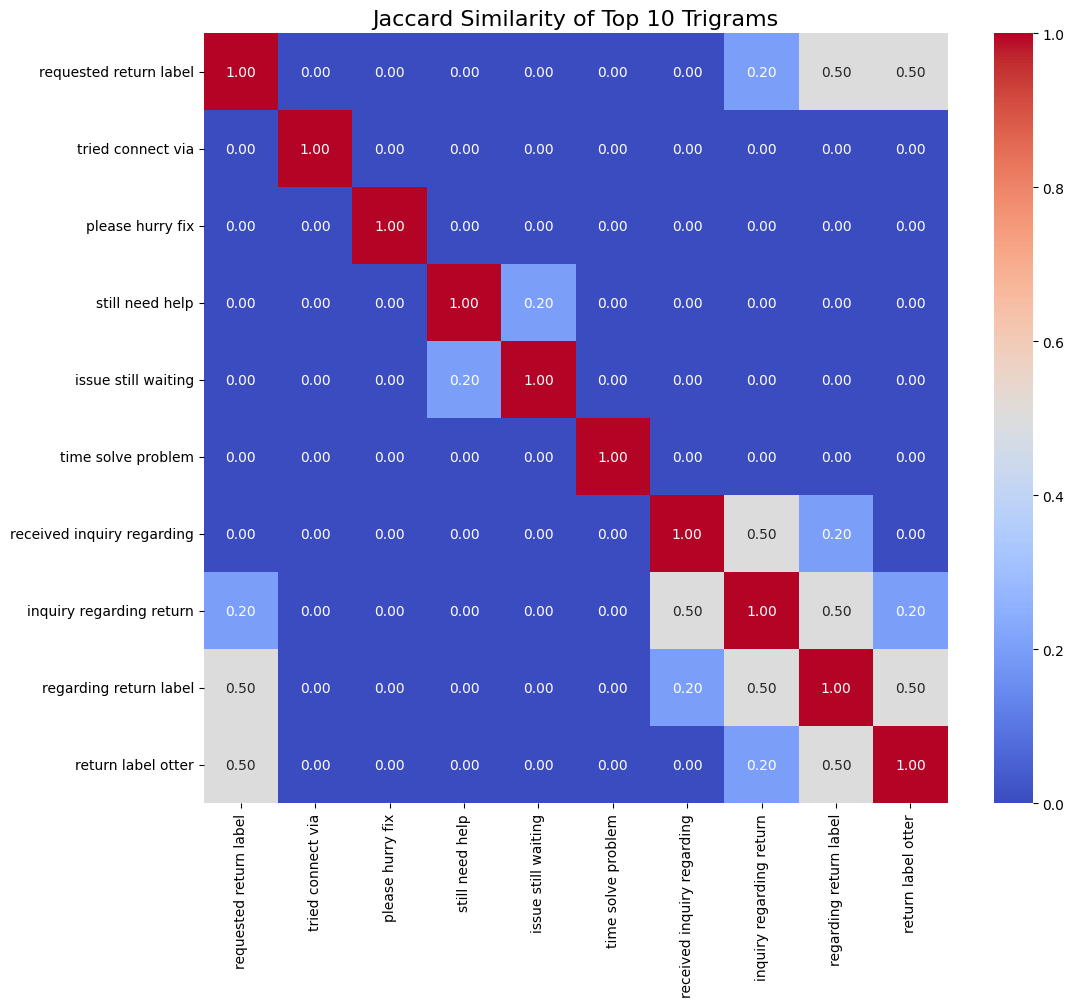

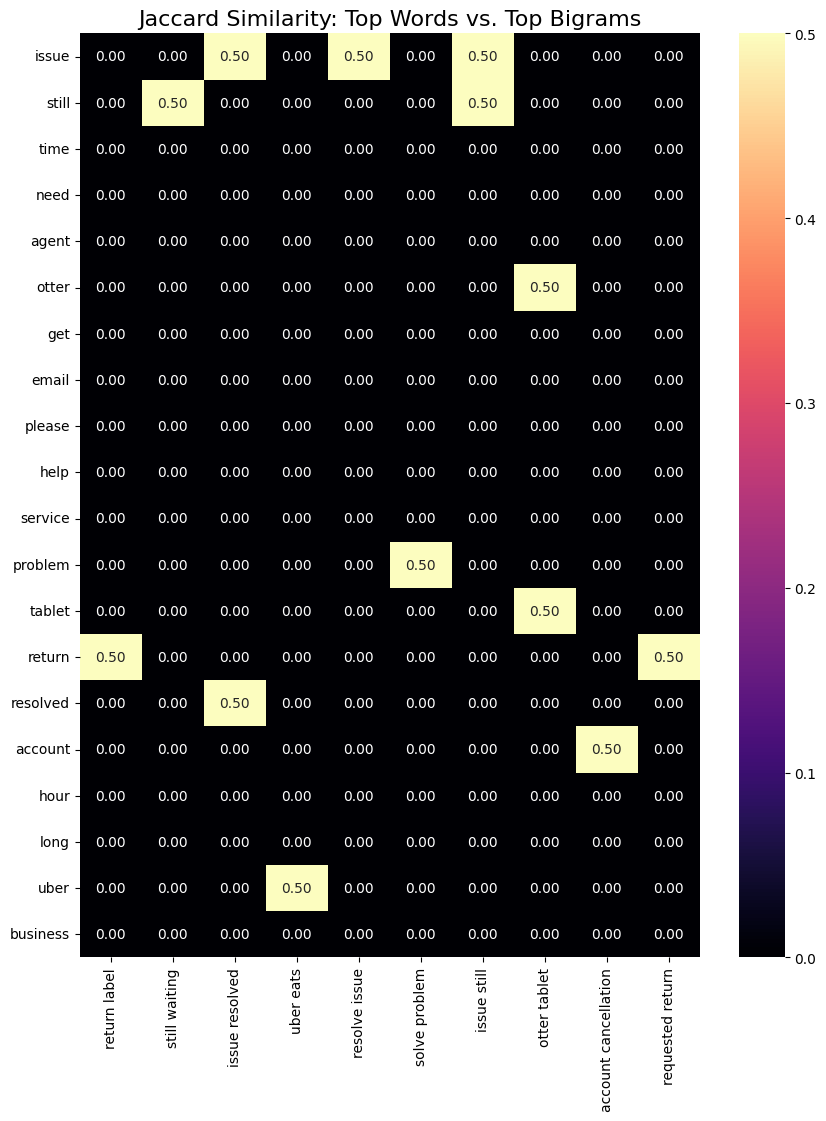

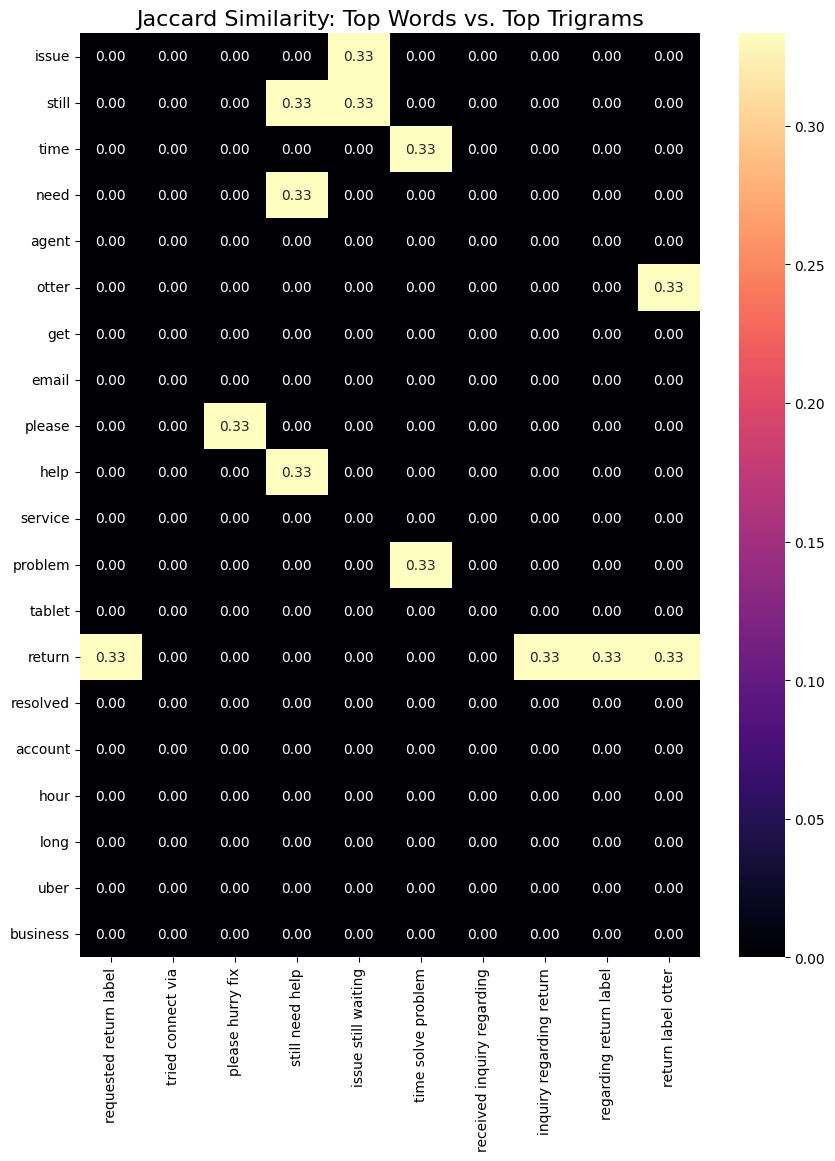

In [20]:
# --- 1. Jaccard Similarity Between Sentiments ---
def get_top_ngrams(tokens, n, N_top):
    """Extracts the top N n-grams from a list of tokens."""
    ngrams_list = tokens if n == 1 else list(nltk.ngrams(tokens, n))
    return [item for item, freq in FreqDist(ngrams_list).most_common(N_top)]

def jaccard_similarity(list1, list2):
    """Calculates Jaccard similarity between two lists."""
    set1, set2 = set(list1), set(list2)
    intersection_len = len(set1.intersection(set2))
    union_len = len(set1.union(set2))
    return intersection_len / union_len if union_len > 0 else 0.0

# Calculate Jaccard similarity for top words and bigrams between sentiments
sentiments = ['Positive', 'Negative', 'Neutral']
tokens_by_sentiment = {s: word_tokenize(" ".join(df[df.sentiment_label == s]['cleaned_text'])) for s in sentiments}
comparisons = [("Positive", "Negative"), ("Positive", "Neutral"), ("Negative", "Neutral")]

results = {
    "Comparison": [f"{s1} vs. {s2}" for s1, s2 in comparisons],
    "Words (Top 20)": [jaccard_similarity(get_top_ngrams(tokens_by_sentiment[s1], 1, 20), get_top_ngrams(tokens_by_sentiment[s2], 1, 20)) for s1, s2 in comparisons],
    "Bigrams (Top 10)": [jaccard_similarity(get_top_ngrams(tokens_by_sentiment[s1], 2, 10), get_top_ngrams(tokens_by_sentiment[s2], 2, 10)) for s1, s2 in comparisons],
    "Trigrams (Top 10)": [jaccard_similarity(get_top_ngrams(tokens_by_sentiment[s1], 3, 10), get_top_ngrams(tokens_by_sentiment[s2], 3, 10)) for s1, s2 in comparisons],
}
similarity_df = pd.DataFrame(results)

# --- 2. Inter-Item Semantic & Jaccard Similarity ---
nlp = spacy.load("en_core_web_md")
top_words_overall = get_top_ngrams(all_tokens, 1, 20) # Top 20 Words
top_bigrams_overall = get_top_ngrams(all_tokens, 2, 10) # Top 10 Bigrams
top_trigrams_overall = get_top_ngrams(all_tokens, 3, 10) # Top 10 Trigrams

# Word vs Word (Semantic Similarity)
matrix_words = np.array([[nlp(w1).similarity(nlp(w2)) for w2 in top_words_overall] for w1 in top_words_overall])
similarity_df_words = pd.DataFrame(matrix_words, index=top_words_overall, columns=top_words_overall)

# Words vs Bigrams (Jaccard Similarity)
matrix_words_vs_bigrams = np.array([[jaccard_similarity([word], list(bigram)) for bigram in top_bigrams_overall] for word in top_words_overall])
similarity_df_words_vs_bigrams = pd.DataFrame(matrix_words_vs_bigrams, index=top_words_overall, columns=[' '.join(g) for g in top_bigrams_overall])

# Words vs Trigrams (Jaccard Similarity)
matrix_words_vs_trigrams = np.array([[jaccard_similarity([word], list(trigram)) for trigram in top_trigrams_overall] for word in top_words_overall])
similarity_df_words_vs_trigrams = pd.DataFrame(matrix_words_vs_trigrams, index=top_words_overall, columns=[' '.join(g) for g in top_trigrams_overall])

# Bigram vs Bigram (Jaccard Similarity)
matrix_bg = np.array([[jaccard_similarity(list(g1), list(g2)) for g2 in top_bigrams_overall] for g1 in top_bigrams_overall])
similarity_df_bigrams = pd.DataFrame(matrix_bg, index=[' '.join(g) for g in top_bigrams_overall], columns=[' '.join(g) for g in top_bigrams_overall])

# Trigram vs Trigram (Jaccard Similarity)
matrix_tg = np.array([[jaccard_similarity(list(g1), list(g2)) for g2 in top_trigrams_overall] for g1 in top_trigrams_overall])
similarity_df_trigrams = pd.DataFrame(matrix_tg, index=[' '.join(g) for g in top_trigrams_overall], columns=[' '.join(g) for g in top_trigrams_overall])


# --- 3. Generate and Save Heatmap Images ---
def create_and_save_heatmap(df_plot, title, filename, annot=False, cmap='viridis', figsize=(12, 10)):
    """Creates, displays, and saves a heatmap from a DataFrame."""
    plt.figure(figsize=figsize)
    sns.heatmap(df_plot, annot=annot, cmap=cmap, fmt=".2f")
    plt.title(title, fontsize=16)
    plt.savefig(os.path.join(OUTPUT_FOLDER_PATH, filename), bbox_inches='tight')
    plt.show()

# Generate and save the heatmaps
create_and_save_heatmap(similarity_df_words, 'Semantic Similarity of Top 20 Words', 'heatmap_words.png')
create_and_save_heatmap(similarity_df_bigrams, 'Jaccard Similarity of Top 10 Bigrams', 'heatmap_bigrams.png', annot=True, cmap='coolwarm')

# ADDED: Heatmap for Trigrams vs Trigrams
create_and_save_heatmap(similarity_df_trigrams, 'Jaccard Similarity of Top 10 Trigrams', 'heatmap_trigrams.png', annot=True, cmap='coolwarm')

# ADDED: Heatmap for Words vs Bigrams
create_and_save_heatmap(similarity_df_words_vs_bigrams, 'Jaccard Similarity: Top Words vs. Top Bigrams', 'heatmap_words_vs_bigrams.png', annot=True, cmap='magma', figsize=(10, 12))

# ADDED: Heatmap for Words vs Trigrams
create_and_save_heatmap(similarity_df_words_vs_trigrams, 'Jaccard Similarity: Top Words vs. Top Trigrams', 'heatmap_words_vs_trigrams.png', annot=True, cmap='magma', figsize=(10, 12))

# Cell 7: Final Report Generation
**This final cell gathers every DataFrame and image and compiles them into a single, multi-sheet Excel report.**

In [21]:
# --- 1. Generate Versioned Filename ---
current_date = datetime.now().strftime('%Y-%m-%d')
base_filename = f"{current_date}_{PROGRAM_NAME}_{KPIS_IN_SCOPE}_{LOBS_IN_SCOPE}_Verbatim_Analysis"
minor_version = 0
while True:
    version_str = f"v{MAJOR_VERSION:02d}.{minor_version:02d}"
    output_filename = f"{base_filename}_{version_str}.xlsx"
    full_path = os.path.join(OUTPUT_FOLDER_PATH, output_filename)
    if not os.path.exists(full_path):
        break
    minor_version += 1

# --- 2. Use ExcelWriter to save all results to dedicated sheets ---
with pd.ExcelWriter(full_path, engine='openpyxl') as writer:
    print(f"\n--- Writing to Excel file: {output_filename} ---")
    
    # --- Sheet 1: Executive Summary ---
    # Write key metrics
    df_summary_metrics.to_excel(writer, sheet_name='Executive_Summary', index=False, startrow=1, startcol=0)
    
    # Write overall category counts table, leaving space
    cat_start_row = len(df_summary_metrics) + 3
    df_cat_counts.to_frame().reset_index().rename(columns={'index': 'Category', 'Category': 'Count'}).to_excel(
        writer, sheet_name='Executive_Summary', index=False, startrow=cat_start_row, startcol=0
    )
    
    # Write overall sub-category counts table, leaving space
    subcat_start_row = cat_start_row + len(df_cat_counts) + 3
    df_subcat_counts.drop('', errors='ignore').to_frame().reset_index().rename(columns={'index': 'Sub-Category', 'Sub-Category': 'Count'}).to_excel(
        writer, sheet_name='Executive_Summary', index=False, startrow=subcat_start_row, startcol=0
    )
    print("Writing Sheet: Executive_Summary")

    # --- Write Main Data and Analysis Sheets ---
    df.to_excel(writer, sheet_name='Categorization_Results', index=False)
    print("Writing Sheet: Categorization_Results")
    
    df_sentiment_by_cat.to_excel(writer, sheet_name='Sentiment_by_Category')
    print("Writing Sheet: Sentiment_by_Category")
    
    df_sentiment_by_subcat.to_excel(writer, sheet_name='Sentiment_by_SubCategory')
    print("Writing Sheet: Sentiment_by_SubCategory")

    if not df_topics.empty:
        df_topics.to_excel(writer, sheet_name='Topic_Modeling', index=False)
        print("Writing Sheet: Topic_Modeling")

    if not df_uncategorized_keywords.empty:
        df_uncategorized_keywords.to_excel(writer, sheet_name='Uncategorized_Keywords', index=False)
        print("Writing Sheet: Uncategorized_Keywords")

    # --- Write Frequency and Similarity Tables to their own sheets ---
    df_top_words.to_excel(writer, sheet_name='Top_Words', index=False)
    print("Writing Sheet: Top_Words")
    df_top_bigrams.to_excel(writer, sheet_name='Top_Bigrams', index=False)
    print("Writing Sheet: Top_Bigrams")
    df_top_trigrams.to_excel(writer, sheet_name='Top_Trigrams', index=False)
    print("Writing Sheet: Top_Trigrams")

    similarity_df.to_excel(writer, sheet_name='Vocab_Similarity', index=False)
    print("Writing Sheet: Vocab_Similarity")
    
    similarity_df_words.to_excel(writer, sheet_name='Word_Similarity_Matrix')
    print("Writing Sheet: Word_Similarity_Matrix")
    
    similarity_df_bigrams.to_excel(writer, sheet_name='Bigram_Similarity_Matrix')
    print("Writing Sheet: Bigram_Similarity_Matrix")
    
    similarity_df_trigrams.to_excel(writer, sheet_name='Trigram_Similarity_Matrix')
    print("Writing Sheet: Trigram_Similarity_Matrix")
    
    similarity_df_words_vs_bigrams.to_excel(writer, sheet_name='Words_vs_Bigrams_Sim')
    print("Writing Sheet: Words_vs_Bigrams_Sim")
    
    similarity_df_words_vs_trigrams.to_excel(writer, sheet_name='Words_vs_Trigrams_Sim')
    print("Writing Sheet: Words_vs_Trigrams_Sim")
    
    # --- Embed Images into the Excel Sheets ---
    workbook = writer.book
    def embed_image(ws_name, img_path, cell_loc):
        if os.path.exists(img_path):
            ws = workbook.create_sheet(title=ws_name)
            img = Image(img_path)
            ws.add_image(img, cell_loc)
            print(f"Embedding Image: {os.path.basename(img_path)} into sheet: {ws_name}")

    # Embed summary charts into Executive Summary sheet
    ws_summary = workbook['Executive_Summary']
    if os.path.exists(os.path.join(OUTPUT_FOLDER_PATH, 'freq_cat_overall.png')):
        img_cat = Image(os.path.join(OUTPUT_FOLDER_PATH, 'freq_cat_overall.png'))
        ws_summary.add_image(img_cat, 'D2') # Position next to category table
    if os.path.exists(os.path.join(OUTPUT_FOLDER_PATH, 'freq_subcat_overall.png')):
        img_subcat = Image(os.path.join(OUTPUT_FOLDER_PATH, 'freq_subcat_overall.png'))
        ws_summary.add_image(img_subcat, f'D{cat_start_row + len(df_cat_counts) + 3}') # Position next to sub-cat table
    
    # Embed all other charts and images into their own dedicated sheets
    embed_image('Sentiment_Chart', os.path.join(OUTPUT_FOLDER_PATH, 'sentiment_distribution.png'), 'A1')
    embed_image('Word_Clouds', os.path.join(OUTPUT_FOLDER_PATH, 'wordcloud_all.png'), 'A1')
    if os.path.exists(os.path.join(OUTPUT_FOLDER_PATH, 'wordcloud_positive.png')):
        workbook['Word_Clouds'].add_image(Image(os.path.join(OUTPUT_FOLDER_PATH, 'wordcloud_positive.png')), 'A25')
    if os.path.exists(os.path.join(OUTPUT_FOLDER_PATH, 'wordcloud_negative.png')):
        workbook['Word_Clouds'].add_image(Image(os.path.join(OUTPUT_FOLDER_PATH, 'wordcloud_negative.png')), 'A50')
    
    embed_image('Heatmap_Word_Sim', os.path.join(OUTPUT_FOLDER_PATH, 'heatmap_words.png'), 'A1')
    embed_image('Heatmap_Bigram_Sim', os.path.join(OUTPUT_FOLDER_PATH, 'heatmap_bigrams.png'), 'A1')
    embed_image('Heatmap_Trigram_Sim', os.path.join(OUTPUT_FOLDER_PATH, 'heatmap_trigrams.png'), 'A1')
    embed_image('Heatmap_Words_v_Bigrams', os.path.join(OUTPUT_FOLDER_PATH, 'heatmap_words_vs_bigrams.png'), 'A1')
    embed_image('Heatmap_Words_v_Trigrams', os.path.join(OUTPUT_FOLDER_PATH, 'heatmap_words_vs_trigrams.png'), 'A1')
    
    embed_image('Charts_Pos_Cats', os.path.join(OUTPUT_FOLDER_PATH, 'freq_cat_positive.png'), 'A1')
    embed_image('Charts_Neg_Cats', os.path.join(OUTPUT_FOLDER_PATH, 'freq_cat_negative.png'), 'A1')
    embed_image('Charts_Neu_Cats', os.path.join(OUTPUT_FOLDER_PATH, 'freq_cat_neutral.png'), 'A1')
    
    embed_image('Charts_Pos_SubCats', os.path.join(OUTPUT_FOLDER_PATH, 'freq_subcat_positive.png'), 'A1')
    embed_image('Charts_Neg_SubCats', os.path.join(OUTPUT_FOLDER_PATH, 'freq_subcat_negative.png'), 'A1')
    embed_image('Charts_Neu_SubCats', os.path.join(OUTPUT_FOLDER_PATH, 'freq_subcat_neutral.png'), 'A1')


print(f"\n✅ All analysis results and plots have been saved to a multi-sheet file:")
print(full_path)


--- Writing to Excel file: 2025-09-22_Cloud Kitchens_CSAT-AHT-Resolution_Time_Support-Scaled_Verbatim_Analysis_v01.00.xlsx ---
Writing Sheet: Executive_Summary
Writing Sheet: Categorization_Results
Writing Sheet: Sentiment_by_Category
Writing Sheet: Sentiment_by_SubCategory
Writing Sheet: Topic_Modeling
Writing Sheet: Uncategorized_Keywords
Writing Sheet: Top_Words
Writing Sheet: Top_Bigrams
Writing Sheet: Top_Trigrams
Writing Sheet: Vocab_Similarity
Writing Sheet: Word_Similarity_Matrix
Writing Sheet: Bigram_Similarity_Matrix
Writing Sheet: Trigram_Similarity_Matrix
Writing Sheet: Words_vs_Bigrams_Sim
Writing Sheet: Words_vs_Trigrams_Sim
Embedding Image: sentiment_distribution.png into sheet: Sentiment_Chart
Embedding Image: wordcloud_all.png into sheet: Word_Clouds
Embedding Image: heatmap_words.png into sheet: Heatmap_Word_Sim
Embedding Image: heatmap_bigrams.png into sheet: Heatmap_Bigram_Sim
Embedding Image: heatmap_trigrams.png into sheet: Heatmap_Trigram_Sim
Embedding Image: he